In [1]:
import loaddata as ld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import math



In [435]:
mj = ld.load_mojo_data()
mc = ld.load_mc_data()

In [441]:
#import copy
nl = []
print(mc[:1])

for dct in mc:
    #c = copy.deepcopy(dct)
    nd = {}
    if type(dct) != type({}) or 'title' not in dct.keys() or type(dct['genre']) != type([]): continue
    nd['title'] = dct['title']
    #nd['director'] = dct['director']
    nd['year'] = dct['year']
    genre = dct['genre']
    for i in xrange(3): genre.append(None)

    nd['genre_0'] = genre[0]
    nd['genre_1'] = genre[1]
    nd['genre_2'] = genre[2]

    nl.append(nd)

[{u'user_score': 7.0, u'rating': u'PG-13', u'complete': True, u'runtime_minutes': 97, u'release_date': u'1999-03-31', u'num_critic_reviews': [18, 7, 1, 26], u'director': u'Gil Junger', u'metascore': 70, u'num_user_ratings': 175, u'metacritic_page': u'/movie/10-things-i-hate-about-you', u'num_user_reviews': [27, 1, 1, 29], u'studio': u'Buena Vista Pictures', u'year': 1999, u'genre': [u'Comedy', u'Romance', None, None, None, None, None, None], u'title': u'10 Things I Hate About You'}]


In [442]:
genre_df = pd.DataFrame(nl)

In [443]:
mj_df = pd.DataFrame(mj)
mc_df = ld.to_df(mc)


In [444]:
#mc_df['ltitle'] = mc_df['title'].map(lambda x: x.lower())
#mj_df['ltitle'] = mc_df['title'].map(lambda x: x.lower())
df = pd.merge(mc_df, mj_df, how = 'inner', on=['title', 'year'])
df = pd.merge(df, genre_df, how = 'inner', on=['title', 'year'])
df_clean = df[df.complete == True]

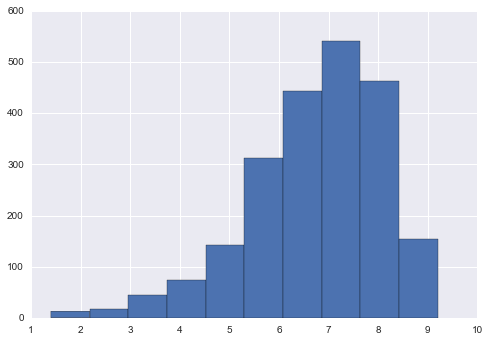

In [365]:
df_clean['user_score'].hist()

In [366]:
df_model = df_clean.dropna(subset = ['domestic_gross', 'opening_per_theater', 'opening_weekend_take', 'release_date_wide', 'widest_release'])

In [367]:
df_model = df_model[df_model['year'] >= 2005]
df_model['growth_factor'] = df_model['domestic_gross'] / df['opening_weekend_take']
df_model[['growth_factor', 'title', 'metascore']].sort('growth_factor', ascending = False)
df_model['opening_theater_count'] = df_model['opening_weekend_take'] / df_model['opening_per_theater']
ratings = pd.get_dummies(df_model['rating'])
df_model = pd.merge(df_model, ratings, left_index = True, right_index = True)
df_model['PG-13'] = df_model['PG-13'] + df_model['PG--13']
del df_model['PG--13']
float_vals = pd.to_numeric(df_model['year'])
df_model = pd.concat([df_model, float_vals], axis = 1)
del df_model['year']
df_model = pd.concat([df_model, float_vals], axis = 1)

In [382]:
df_model['lim_release'] = df_model['release_date_limited'].isnull()
df_full_release = df_model[df_model['lim_release'] == True]
df_lim_release = df_model[df_model['lim_release'] == False]

In [385]:
# splits x -> x_train, x_test
#        y -> y_train, y_test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.33)

def RMSE(model, X_, Y_):
    Y_pred = model.predict(X_)
    Y_true = Y_
    MSE = mean_squared_error(Y_pred, Y_true)
    return np.sqrt(MSE)


In [386]:
train_RMSE = RMSE(linmodel, X_train, Y_train)
test_RMSE  = RMSE(linmodel, X_test, Y_test)

print 'Training RMSE is %.1f' % (train_RMSE)
print 'Test RMSE     is %.1f' % (test_RMSE)

Training RMSE is 14.6
Test RMSE     is 18.7


In [387]:
df_model.columns
df_model['log_growth'] = df_model['growth_factor'].map(lambda x: math.log(x))

In [388]:
df_model['opening_per_theater_sq'] = df_model['opening_per_theater'].map(lambda x: x**2)

In [389]:
df_model['opening_per_theater_cube'] = df_model['opening_per_theater'].map(lambda x: x**3)

In [390]:
df_model['lim_release'] = df_model['release_date_limited'].isnull()
df_full_release = df_model[df_model['lim_release'] == True]
df_lim_release = df_model[df_model['lim_release'] == False]

In [391]:
df_full_release = df_full_release[df_full_release['year'] < 2015]

In [392]:
df_full_release_small_only = df_full_release[df_full_release['opening_theater_count']<100]

In [419]:
Y = df_full_release_small_only.log_growth
X = sm.add_constant(df_full_release_small_only[['opening_theater_count', 'opening_per_theater',
                                     'opening_per_theater_sq', 'opening_per_theater_cube',
                                     'metascore']])

In [420]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.33)

In [421]:
linmodel = sm.OLS(Y_train,X_train).fit()

In [422]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_growth   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     138.1
Date:                Fri, 15 Apr 2016   Prob (F-statistic):           1.67e-75
Time:                        11:01:48   Log-Likelihood:                -481.26
No. Observations:                 430   AIC:                             972.5
Df Residuals:                     425   BIC:                             992.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                        0.0003    1.7e-05     18.651      0.000         0.000     0.000
opening_theater_count       -0.0038      0.002     -1.677      0.094        -0.008     0.001
opening_per_theater          0.0001    9.1e-06     11.842      0.000      8.99e-05     0.000
opening_per_theater_sq    -1.53e-09   2.04e-10     -7.490      0.000     -1.93e-09 -1.13e-09
opening_per_theater_cube  4.973e-15   8.22e-16      6.048      0.000      3.36e-15  6.59e-15
metascore                    0.0246      0.001     20.142      0.000         0.022     0.027
==============================================================================
Omnibus:                        9.399   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.543
Skew:                           0.364   Prob(JB):                      0.00847
Kurtosis:                       3.048   Cond. No.                     1.96e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [423]:
train_RMSE = RMSE(linmodel, X_train, Y_train)
test_RMSE  = RMSE(linmodel, X_test, Y_test)

print 'Training RMSE is %.1f' % (train_RMSE)
print 'Test RMSE     is %.1f' % (test_RMSE)

Training RMSE is 0.7
Test RMSE     is 0.7


In [424]:
Y_pred_train = linmodel.predict(X_train)
Residual = Y_train - Y_pred_train


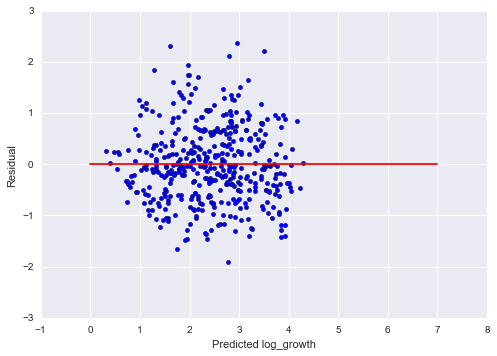

In [425]:
plt.scatter(Y_pred_train, Residual)
#plt.plot([0,700000000], [0,0], color = 'r')
plt.xlabel('Predicted log_growth')
plt.ylabel('Residual')
plt.plot([0,7], [0,0], color = 'r')

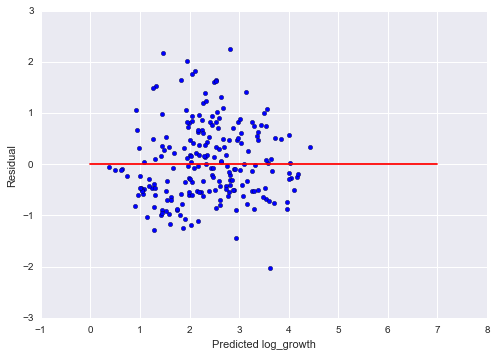

In [426]:
Y_pred_test = linmodel.predict(X_test)
Residual_test = Y_test - Y_pred_test

plt.scatter(Y_pred_test, Residual_test)
#plt.plot([0,700000000], [0,0], color = 'r')
plt.xlabel('Predicted log_growth')
plt.ylabel('Residual')
plt.plot([0,7], [0,0], color = 'r')

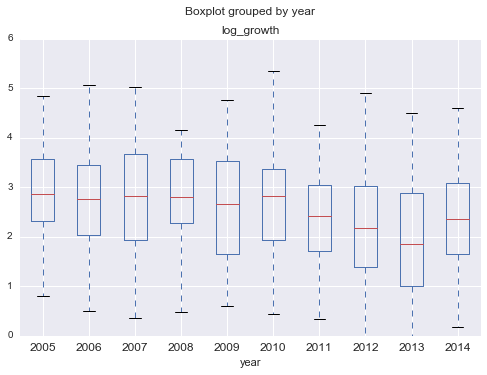

In [427]:
df_full_release_small_only.boxplot( column = 'log_growth', by = 'year')

In [428]:
pd.concat([X_test, Residual_test], axis = 1).sort('log_growth')

c:\Users\JBK988\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,const,opening_theater_count,opening_per_theater,opening_per_theater_sq,opening_per_theater_cube,metascore,log_growth
772,1,1.000000,21065.0,4.437342e+08,9.347261e+12,81.0,-2.022466
1026,1,4.999910,11115.0,1.235432e+08,1.373183e+12,79.0,-1.448682
1654,1,1.000000,72.0,5.184000e+03,3.732480e+05,52.0,-1.280893
801,1,14.993111,871.0,7.586410e+05,6.607763e+08,75.0,-1.246799
440,1,1.000000,5715.0,3.266122e+07,1.866589e+11,60.0,-1.186132
1741,1,22.988359,859.0,7.378810e+05,6.338398e+08,65.0,-1.159700
1473,1,2.000605,1654.0,2.735716e+06,4.524874e+09,82.0,-1.114864
187,1,1.000000,7143.0,5.102245e+07,3.644534e+11,50.0,-1.068701
334,1,2.000000,2165.0,4.687225e+06,1.014784e+10,38.0,-1.033123
875,1,1.999516,2066.0,4.268356e+06,8.818423e+09,65.0,-0.991285


In [429]:
pd.merge(df_full_release_small_only, X, how = 'inner', left_index = True, right_index=True)

,complete,director_x,metacritic_page,metascore_x,num_user_ratings,rating,release_date,runtime_minutes,studio,title,...,year,log_growth,opening_per_theater_sq_x,opening_per_theater_cube_x,const,opening_theater_count_y,opening_per_theater_y,opening_per_theater_sq_y,opening_per_theater_cube_y,metascore_y
1,True,Jamie Linden,/movie/10-years,61.0,12.0,R,2012-09-14,100.0,Anchor Bay Entertainment,10 Years,...,2012,2.192368,5.728976e+07,4.336262e+11,1,3.000000,7569.0,5.728976e+07,4.336262e+11,61.0
5,True,Daniel Stamm,/movie/13-sins,44.0,21.0,R,2014-04-18,88.0,Dimension Films,13 Sins,...,2014,0.399509,4.243600e+04,8.741816e+06,1,44.956311,206.0,4.243600e+04,8.741816e+06,44.0
6,True,Géla Babluani,/movie/13-tzameti,61.0,19.0,Not Rated,2006-07-28,93.0,Palm Pictures,13 Tzameti,...,2006,2.419000,1.167480e+08,1.261462e+12,1,1.000000,10805.0,1.167480e+08,1.261462e+12,61.0
10,True,Julie Delpy,/movie/2-days-in-new-york,61.0,21.0,R,2012-08-10,96.0,Magnolia Pictures,2 Days in New York,...,2012,3.275168,1.433048e+08,1.715502e+12,1,2.000000,11971.0,1.433048e+08,1.715502e+12,61.0
11,True,Julie Delpy,/movie/2-days-in-paris,67.0,66.0,R,2007-08-10,96.0,Samuel Goldwyn Films,2 Days in Paris,...,2007,3.240066,3.015085e+08,5.235394e+12,1,10.000058,17364.0,3.015085e+08,5.235394e+12,67.0
14,True,Morgan Neville,/movie/20-feet-from-stardom,83.0,33.0,PG-13,2013-06-14,91.0,RADiUS-TWC,20 Feet from Stardom,...,2013,4.506464,3.312036e+08,6.027574e+12,1,2.999945,18199.0,3.312036e+08,6.027574e+12,83.0
16,True,Kar Wai Wong,/movie/2046,78.0,84.0,R,2005-08-05,129.0,Sony Pictures Classics,2046,...,2005,2.547537,7.990798e+08,2.258839e+13,1,4.000071,28268.0,7.990798e+08,2.258839e+13,78.0
31,True,Claire Denis,/movie/35-shots-of-rum,92.0,49.0,Not Rated,2009-09-16,100.0,Cinema Guild,35 Shots of Rum,...,2009,2.919773,9.169978e+07,8.781171e+11,1,1.000000,9576.0,9.169978e+07,8.781171e+11,92.0
32,True,Fernando Meirelles,/movie/360,43.0,40.0,R,2012-08-03,110.0,Magnolia Pictures,360,...,2012,2.108307,3.712465e+07,2.262005e+11,1,2.000000,6093.0,3.712465e+07,2.262005e+11,43.0
36,True,Renny Harlin,/movie/5-days-of-war,31.0,38.0,R,2011-08-19,120.0,Anchor Bay Films,5 Days of War,...,2011,1.027779,9.778129e+06,3.057621e+10,1,2.000000,3127.0,9.778129e+06,3.057621e+10,31.0


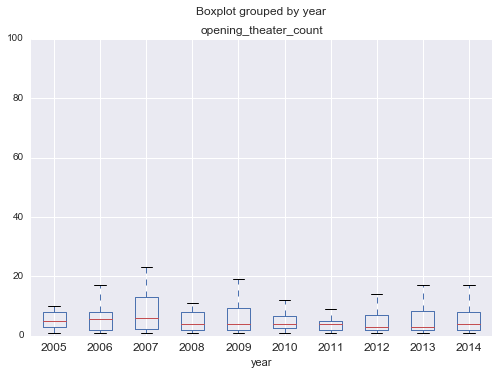

In [410]:
df_full_release_small_only.boxplot( column = 'opening_theater_count', by = 'year')